In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST

In [2]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # flatten input tensor
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [3]:
# Function to calculate accuracy of the model
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy


In [4]:
# Parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

In [5]:
# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
# Load dataset
dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_set, val_set = random_split(dataset, [50000, 10000])  # Split dataset into training and validation sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)


100%|██████████| 26421880/26421880 [00:01<00:00, 16145814.15it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272290.31it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5003374.70it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5385950.86it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [7]:
# Model instantiation and optimizer definition
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
# Function to compute similarity matrix between weights
def compute_similarity_matrix(model):
    similarity_matrices = []
    for param in model.parameters():
        if len(param.data.size()) > 1:  # Only for weights
            weight_data = param.data.view(param.data.size(0), -1)  # Convert weights to a vector
            similarity_matrix = torch.cdist(weight_data, weight_data, p=2)  # Compute distance matrix
            similarity_matrices.append(similarity_matrix)
    return similarity_matrices


In [11]:
# Function to prune weights based on similarity
def prune_weights(model, similarity_matrices, prune_percentage):
    with torch.no_grad():
        index = 0
        for name, param in model.named_parameters():
            if len(param.data.size()) > 1:  # Only for weights
                similarity_matrix = similarity_matrices[index]
                num_prune = int(similarity_matrix.numel() * prune_percentage)
                _, indices = torch.topk(similarity_matrix.view(-1), num_prune)

                # Create a mask of ones with the same shape as the weight parameter
                mask = torch.ones_like(param.data)

                # Flatten the mask and set the indices corresponding to low similarity weights to 0
                mask_flat = mask.view(-1)
                mask_flat[indices] = 0

                # Reshape the flattened mask to match the shape of the weight parameter
                mask = mask_flat.view(param.data.shape)

                # Apply the mask to the weight parameter
                param.data *= mask
                index += 1


In [15]:

import matplotlib.pyplot as plt

# Lists to store the results
pruning_details = []
accuracy_vs_pruning = []

# Pruning percentages
prune_percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]   # Different pruning percentages
max_pruning_with_no_accuracy_drop = 0
max_accuracy = 0






In [17]:
def num_pruned_weights(model):
    num_pruned = 0
    for name, param in model.named_parameters():
        if len(param.data.size()) > 1:  # Only for weights
            num_pruned += (param.data == 0).sum().item()
    return num_pruned


In [21]:
for prune_percentage in prune_percentages:
    # Compute similarity matrices
    similarity_matrices = compute_similarity_matrix(model)

    # Prune low similarity weights
    prune_weights(model, similarity_matrices, prune_percentage)
    print(f"prune percentage {prune_percentage * 100} %")
    # Train model with pruned weights
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Compute accuracy on validation set
        accuracy = evaluate_accuracy(model, val_loader)

        # Record the results
        pruning_details.append((prune_percentage, epoch+1, running_loss/len(train_loader), accuracy, num_pruned_weights(model)))

        # Update maximum pruning percentage with no accuracy drop
        if accuracy > max_accuracy:
            max_accuracy = accuracy
            max_pruning_with_no_accuracy_drop = prune_percentage

        # Report results
        print(f"Pruning Percentage: {prune_percentage * 100}٪, Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Accuracy on Validation Set: {accuracy}, Number of Pruned Weights: {num_pruned_weights(model)}")

    # Record accuracy for plotting
    accuracy_vs_pruning.append((prune_percentage, accuracy))

prune percentage 10.0 %
Pruning Percentage: 10.0٪, Epoch 1, Training Loss: 0.1008360286760132, Accuracy on Validation Set: 0.8907, Number of Pruned Weights: 11721
Pruning Percentage: 10.0٪, Epoch 2, Training Loss: 0.09668103275913507, Accuracy on Validation Set: 0.8899, Number of Pruned Weights: 11593
Pruning Percentage: 10.0٪, Epoch 3, Training Loss: 0.10002667143050095, Accuracy on Validation Set: 0.8807, Number of Pruned Weights: 11461
Pruning Percentage: 10.0٪, Epoch 4, Training Loss: 0.0863420534861105, Accuracy on Validation Set: 0.8914, Number of Pruned Weights: 11326
Pruning Percentage: 10.0٪, Epoch 5, Training Loss: 0.09458072957001588, Accuracy on Validation Set: 0.8913, Number of Pruned Weights: 11246
Pruning Percentage: 10.0٪, Epoch 6, Training Loss: 0.09017613829980554, Accuracy on Validation Set: 0.8904, Number of Pruned Weights: 11154
Pruning Percentage: 10.0٪, Epoch 7, Training Loss: 0.08383217965052618, Accuracy on Validation Set: 0.8849, Number of Pruned Weights: 1112

Maximum pruning percentage with no accuracy drop: 0.3
Area under the curve: 0.71087
Area under the curve is less than 75%


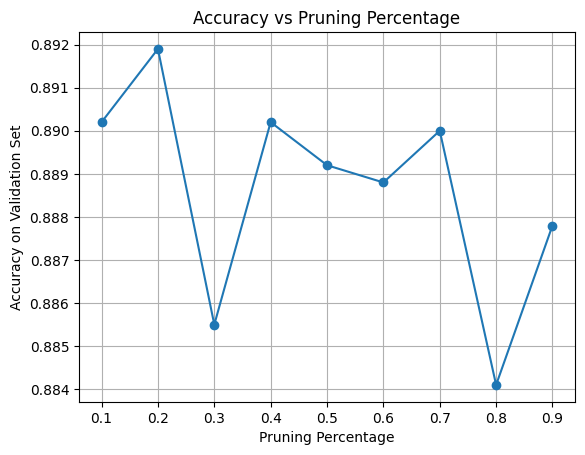

In [22]:
# Plot accuracy vs pruning percentage
pruning_percentages, accuracies = zip(*accuracy_vs_pruning)
plt.plot(pruning_percentages, accuracies, marker='o', linestyle='-')
plt.xlabel('Pruning Percentage')
plt.ylabel('Accuracy on Validation Set')
plt.title('Accuracy vs Pruning Percentage')
plt.grid(True)

# Calculate area under the curve
area_under_curve = 0
for i in range(1, len(pruning_percentages)):
    area_under_curve += (pruning_percentages[i] - pruning_percentages[i-1]) * (accuracies[i] + accuracies[i-1]) / 2

print(f"Maximum pruning percentage with no accuracy drop: {max_pruning_with_no_accuracy_drop}")
print(f"Area under the curve: {area_under_curve}")

# Check if area under the curve is at least 75%
if area_under_curve >= 0.75:
    print("Area under the curve is at least 75%")
else:
    print("Area under the curve is less than 75%")

plt.show()

-----------------------------------------------------
